In [105]:
# Import required libraries
import pandas as pd
import numpy as np
# import duckdb
# import os
from unidecode import unidecode



# Combine Spotify Datasets

In [ ]:
# # Path to SQLite database (relative to notebook root)
# sqlite_file = "../data/extracted.db"

# # Connect to DuckDB (in-memory)
# con = duckdb.connect(database=':memory:')

# # Attach SQLite database so we can query its tables via sqlite_db.<table>
# con.execute(f"ATTACH DATABASE '{sqlite_file}' AS sqlite_db;")

# # List tables in the attached SQLite database
# tables = [r[0] for r in con.execute("SHOW TABLES FROM sqlite_db;").fetchall()]
# print("Tables:", tables)

# if not tables:
#     print("No tables found in the attached sqlite database. Check the path or contents of:", sqlite_file)
# else:
#     out_dir = '../data/parquet'
#     os.makedirs(out_dir, exist_ok=True)

#     # Save each table to a parquet file in data/parquet/<table>.parquet
#     for table_name in tables:
#         out_path = os.path.join(out_dir, f"{table_name}.parquet")
#         sql = f"COPY (SELECT * FROM sqlite_db.{table_name}) TO '{out_path}' (FORMAT PARQUET);"
#         print(f"Exporting table '{table_name}' -> {out_path}")
#         con.execute(sql)
#         print(f"Saved {table_name} to {out_path}")

#     print("Done exporting tables to Parquet.")


In [106]:
spot_huge_df = pd.read_parquet('../data/extracted.parquet')
spot_new_df = pd.read_csv('../data/spotify_data.csv')
spot_old_df = pd.read_parquet('../data/spotify.parquet')

In [107]:
spot_huge_df.columns

Index(['track_uri', 'track_name', 'artist_name', 'artist_uri', 'album_name',
       'album_uri', 'duration_ms', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'type', 'id', 'uri', 'track_href', 'analysis_url',
       'fduration_ms', 'time_signature'],
      dtype='object')

In [108]:
spot_new_df.columns

Index(['Unnamed: 0', 'artist_name', 'track_name', 'track_id', 'popularity',
       'year', 'genre', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'time_signature'],
      dtype='object')

In [109]:
spot_old_df.columns

Index(['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name',
       'popularity', 'duration_ms', 'explicit', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
       'track_genre'],
      dtype='object')

In [110]:
set(spot_old_df) - set(spot_huge_df), set(spot_old_df) - set(spot_new_df)

({'Unnamed: 0',
  'artists',
  'explicit',
  'popularity',
  'track_genre',
  'track_id'},
 {'album_name', 'artists', 'explicit', 'track_genre'})

In [111]:
spot_new_df['popularity'].quantile(0.25), spot_new_df['popularity'].quantile(0.5), spot_new_df['popularity'].quantile(0.75), spot_new_df['popularity'].mean()

(np.float64(5.0),
 np.float64(15.0),
 np.float64(29.0),
 np.float64(18.38312277325387))

In [112]:
spot_old_df = spot_old_df.rename(columns = {'artists' : 'artist_name'})
spot_new_df = spot_new_df.rename(columns = {'genre' : 'track_genre'})
spot_new_df['explicit'] = np.nan
spot_huge_df['popularity'] = np.nan
spot_huge_df['track_genre'] = np.nan
spot_huge_df['explicit'] = np.nan

In [113]:
set(spot_old_df) - set(spot_huge_df), set(spot_old_df) - set(spot_new_df)

({'Unnamed: 0', 'track_id'}, {'album_name'})

In [114]:
spotify_df = pd.concat([
            spot_old_df[['artist_name', 'track_name',
                        'popularity', 'duration_ms', 'explicit', 'danceability', 'energy',
                        'key', 'loudness', 'mode', 'speechiness', 'acousticness',
                        'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
                        'track_genre']],
            spot_new_df[['artist_name', 'track_name', 
                         'popularity', 'duration_ms', 'explicit', 'danceability', 'energy', 
                         'key', 'loudness', 'mode', 'speechiness', 'acousticness', 
                         'instrumentalness', 'liveness', 'valence', 'tempo',  'time_signature', 
                         'track_genre']],
            spot_huge_df[['artist_name','track_name', 
                          'popularity', 'duration_ms', 'explicit', 'danceability', 'energy', 
                          'key', 'loudness', 'mode', 'speechiness', 'acousticness', 
                          'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
                          'track_genre']]
        ],
        ignore_index=True
    )


In [115]:
spotify_df = spotify_df.drop_duplicates()

In [116]:
spotify_df.shape

(3528327, 18)

In [117]:
spotify_df['popularity'].isnull().sum()

np.int64(2261614)

In [118]:
spotify_df.isnull().sum().sort_values(ascending=False)

explicit            3421378
track_genre         2261614
popularity          2261614
artist_name              16
track_name                2
duration_ms               0
danceability              0
energy                    0
key                       0
loudness                  0
speechiness               0
acousticness              0
instrumentalness          0
liveness                  0
valence                   0
tempo                     0
time_signature            0
mode                      0
dtype: int64

In [119]:
# drop artists with null values
spotify_df = spotify_df.dropna(subset=['artist_name']).reset_index(drop=True)

In [ ]:
# here I saved Spotify Dataset for feature engineering
spotify_df.to_parquet('../data/spotify_musics.parquet')

In [16]:
audio_cols = [
    'danceability', 'energy', 'valence', 'tempo',
    'acousticness', 'instrumentalness', 'liveness', 'speechiness'
]

# Add popularity and number of tracks
artist_audio_stats = (
    spotify_df.groupby('artist_name')
    .agg({
        **{col: ['mean', 'median', 'min', 'max', 'std'] for col in audio_cols},
        'popularity': ['mean', 'median', 'min', 'max', 'std'],
        'track_name': 'count'  # assuming 'track_name' uniquely identifies a track
    })
)

# Flatten multi-level columns
artist_audio_stats.columns = [
    '_'.join(col).strip() if col[1] != '' else col[0]
    for col in artist_audio_stats.columns.values
]

# Rename track count column for clarity
artist_audio_stats.rename(columns={'track_id_count': 'num_tracks'}, inplace=True)

# Reset index
artist_audio_stats.reset_index(inplace=True)


In [17]:
artist_audio_stats.head()

,artist_name,danceability_mean,danceability_median,danceability_min,danceability_max,danceability_std,energy_mean,energy_median,energy_min,energy_max,...,speechiness_median,speechiness_min,speechiness_max,speechiness_std,popularity_mean,popularity_median,popularity_min,popularity_max,popularity_std,track_name_count
0,Rip­-Off,0.764000,0.7640,0.764,0.764,NaN,0.512000,0.5120,0.512,0.512,...,0.06300,0.0630,0.0630,NaN,NaN,NaN,NaN,NaN,NaN,1
1,Superior,0.750000,0.7500,0.750,0.750,NaN,0.917000,0.9170,0.917,0.917,...,0.28800,0.2880,0.2880,NaN,NaN,NaN,NaN,NaN,NaN,1
2,!!!,0.738492,0.7545,0.449,0.934,0.097898,0.791383,0.8115,0.347,0.992,...,0.05655,0.0271,0.2610,0.041614,21.795455,22.0,5.0,43.0,9.787461,128
3,!Dela Dap,0.777167,0.7760,0.578,0.970,0.098220,0.750972,0.7320,0.502,0.941,...,0.05875,0.0307,0.2260,0.043921,NaN,NaN,NaN,NaN,NaN,36
4,!Distain,0.612500,0.6125,0.585,0.640,0.038891,0.885000,0.8850,0.878,0.892,...,0.04800,0.0463,0.0497,0.002404,NaN,NaN,NaN,NaN,NaN,2


In [18]:
artist_audio_stats.isnull().sum().sort_values(ascending=False)

popularity_std             271524
popularity_max             245661
popularity_min             245661
popularity_median          245661
popularity_mean            245661
acousticness_std           145271
instrumentalness_std       145271
danceability_std           145271
speechiness_std            145271
tempo_std                  145271
energy_std                 145271
valence_std                145271
liveness_std               145271
instrumentalness_median         0
instrumentalness_max            0
instrumentalness_min            0
liveness_median                 0
liveness_mean                   0
artist_name                     0
liveness_min                    0
liveness_max                    0
instrumentalness_mean           0
speechiness_median              0
speechiness_min                 0
speechiness_max                 0
speechiness_mean                0
acousticness_min                0
acousticness_max                0
danceability_mean               0
danceability_m

Nulls are in just std columns in which it is caused by just 1 observations, and popularity columns, as popularity for many of the instances is null due to no information about that in one of the Spotify datasets.

In [19]:
spotify_df = spotify_df.merge(artist_audio_stats, on='artist_name', how='left')

In [20]:
# Sort by artist and popularity (NaNs will go last automatically)
# If popularity is not Nan, keep the most popular track per artist, otherwise keep the first occurrence
spotify_df = (
    spotify_df.sort_values(['artist_name', 'popularity'], ascending=[True, False])
              .drop_duplicates('artist_name', keep='first')
              .reset_index(drop=True)
)

In [21]:
spotify_df['artist_name'].isnull().sum()

np.int64(0)

In [22]:
spotify_df.shape

(329401, 64)

In [23]:
spotify_df.artist_name.duplicated().sum()

np.int64(0)

In [24]:
spotify_df.columns

Index(['artist_name', 'track_name', 'popularity', 'duration_ms', 'explicit',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'time_signature', 'track_genre', 'danceability_mean',
       'danceability_median', 'danceability_min', 'danceability_max',
       'danceability_std', 'energy_mean', 'energy_median', 'energy_min',
       'energy_max', 'energy_std', 'valence_mean', 'valence_median',
       'valence_min', 'valence_max', 'valence_std', 'tempo_mean',
       'tempo_median', 'tempo_min', 'tempo_max', 'tempo_std',
       'acousticness_mean', 'acousticness_median', 'acousticness_min',
       'acousticness_max', 'acousticness_std', 'instrumentalness_mean',
       'instrumentalness_median', 'instrumentalness_min',
       'instrumentalness_max', 'instrumentalness_std', 'liveness_mean',
       'liveness_median', 'liveness_min', 'liveness_max', 'liveness_std',
       'speechiness_mean'

In [ ]:
spotify_df.to_parquet('../data/spotify_combined.parquet', index=False)

# Get Artists Dataset from last.fm & Merge on Spotify

In [25]:
artists_df = pd.read_csv('../data/artists.dat', sep='\t')
spotify_df = pd.read_parquet('../data/spotify_combined.parquet')

In [26]:
import re

def clean_artist_name(name):
    name = name.lower().strip()
    name = re.sub(r'[\(\)\[\]\{\}]+', '', name)  # remove brackets
    name = re.sub(r'\s+', ' ', name)             # normalize spaces
    return name

artists_df['name_clean'] = artists_df['name'].apply(clean_artist_name)
spotify_df['artists_clean'] = spotify_df['artist_name'].apply(clean_artist_name)


In [27]:
spotify_df['artists_clean'].duplicated().sum()

np.int64(1811)

In [28]:
artists_df.shape

(17632, 5)

In [29]:
from unidecode import unidecode

artists_df['name_translit'] = artists_df['name_clean'].apply(lambda x: unidecode(x)).str.lower()
spotify_df['artists_translit'] = spotify_df['artists_clean'].apply(lambda x: unidecode(x)).str.lower()

In [30]:
artists_df['name_translit'].duplicated().sum()

np.int64(74)

In [31]:
spotify_df['artists_translit'].duplicated().sum()

np.int64(2447)

It seems like that the same artists are mentioend with different names in both of the datasets

In [32]:
from rapidfuzz import process, fuzz
import pandas as pd

def fuzzy_match_chunked(query_names, candidate_names, chunk_size=10000, threshold=80):
    best_matches = [(None, 0)] * len(query_names)
    
    for i in range(0, len(candidate_names), chunk_size):
        chunk = candidate_names[i:i+chunk_size]
        matches_chunk = process.cdist(query_names, chunk, scorer=fuzz.ratio, processor=None)
        
        # Update best matches
        for idx, row in enumerate(matches_chunk):
            max_score = max(row)
            if max_score > best_matches[idx][1] and max_score >= threshold:
                max_idx = row.argmax()
                best_matches[idx] = (chunk[max_idx], max_score)
                
    return best_matches

query_names = artists_df['name_translit'].dropna().tolist()
candidate_names = spotify_df['artists_translit'].dropna().unique()

matches = fuzzy_match_chunked(query_names, candidate_names, chunk_size=10000, threshold=80)
artists_df[['spotify_match', 'similarity']] = pd.DataFrame(matches, index=artists_df.index)


In [33]:
artists_df[artists_df['similarity'] > 60].shape

(14862, 8)

In [34]:
artists_df[['name_translit', 'spotify_match', 'similarity']]

,name_translit,spotify_match,similarity
0,malice mizer,None,0.000000
1,diary of dreams,diary of dreams,100.000000
2,carpathian forest,carpathian forest,100.000000
3,moi dix mois,None,0.000000
4,bella morte,bella morte,100.000000
...,...,...,...
17627,diamanda galas,diamanda galas,100.000000
17628,aya rl,aya rl,100.000000
17629,coptic rain,arctic rain,81.818184
17630,oz alchemist,alchemist,85.714287


In [35]:
artists_df[artists_df['similarity'] == 0].shape[0] / artists_df.shape[0]

0.15710072595281308

<Axes: >

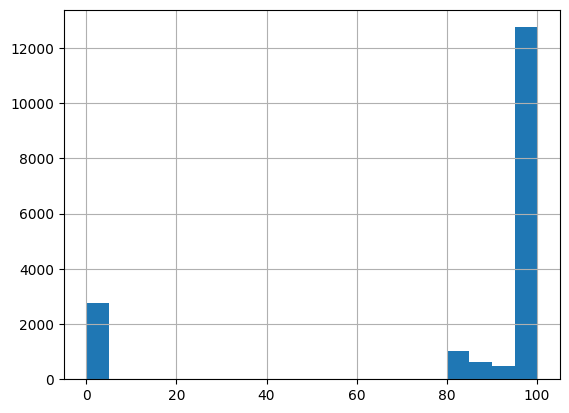

In [36]:
artists_df['similarity'].hist(bins=20)

Based on the Levenshtein distances we calculated, some artists did not have an exact match, but many had similarity scores between 80% and 100%. Approximately 15% of the artists could not be matched to any entry in the Spotify dataset, even when considering Levenshtein distance. For matches with a similarity above 80% but below 100%, most cases appear correct, with differences typically due to typos or minor variations in spelling. However, there are occasional mismatches, such as "Bob Marley" being incorrectly matched to "Jacob Marley." Despite these few errors, we decided to retain matches with scores above 80% for future purposes, as the majority seem reliable.

In [37]:
artists_df = artists_df.merge(spotify_df, left_on='spotify_match', right_on='artists_translit', how='left')

In [38]:
artists_df.head()

,id,name,url,pictureURL,name_clean,name_translit,spotify_match,similarity,artist_name,track_name,...,speechiness_max,speechiness_std,popularity_mean,popularity_median,popularity_min,popularity_max,popularity_std,track_name_count,artists_clean,artists_translit
0,1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,http://userserve-ak.last.fm/serve/252/10808.jpg,malice mizer,malice mizer,None,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,http://userserve-ak.last.fm/serve/252/3052066.jpg,diary of dreams,diary of dreams,diary of dreams,100.0,Diary Of Dreams,Beyond the Void,...,0.0846,0.012713,18.857143,17.0,4.0,34.0,8.283012,88.0,diary of dreams,diary of dreams
2,3,Carpathian Forest,http://www.last.fm/music/Carpathian+Forest,http://userserve-ak.last.fm/serve/252/40222717...,carpathian forest,carpathian forest,carpathian forest,100.0,Carpathian Forest,Bloody Fucking Nekro Hell,...,0.2980,0.053348,14.512500,14.0,3.0,36.0,6.873161,103.0,carpathian forest,carpathian forest
3,4,Moi dix Mois,http://www.last.fm/music/Moi+dix+Mois,http://userserve-ak.last.fm/serve/252/54697835...,moi dix mois,moi dix mois,None,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,Bella Morte,http://www.last.fm/music/Bella+Morte,http://userserve-ak.last.fm/serve/252/14789013...,bella morte,bella morte,bella morte,100.0,Bella Morte,Fall No More,...,0.2970,0.036412,4.627907,3.0,0.0,19.0,3.964265,65.0,bella morte,bella morte


In [39]:
artists_df.duplicated(subset=['name', 'spotify_match']).sum()

np.int64(461)

In [40]:
artists_df = artists_df.drop_duplicates(subset=['name'])

In [ ]:
artists_df = artists_df.drop(columns=['name_clean', 'name_translit', 'spotify_match',
                                      'url', 'pictureURL'])

artists_df = artists_df.rename(columns={'name': 'artist_name_lastfm',
                                        'artist_name' : 'artist_name_spotify',
                                        'track_name': 'top_track_name',
                                      'popularity': 'top_track_popularity',
                                      'duration_ms': 'top_track_duration_ms',
                                      'explicit': 'top_track_explicit',
                                      'danceability': 'top_track_danceability',
                                      'energy': 'top_track_energy',
                                      'key': 'top_track_key',
                                      'loudness': 'top_track_loudness',
                                      'mode': 'top_track_mode',
                                      'speechiness': 'top_track_speechiness',
                                      'acousticness': 'top_track_acousticness',
                                      'instrumentalness': 'top_track_instrumentalness',
                                      'liveness': 'top_track_liveness',
                                      'valence': 'top_track_valence',
                                      'tempo': 'top_track_tempo',
                                      'time_signature': 'top_track_time_signature',
                                      'track_genre': 'top_track_genre',
                                      'similarity': 'levenshtein_similarity',
                                      })


In [46]:
# Compute correlation matrix for numeric columns only
corr_matrix = artists_df.select_dtypes(include=[np.number]).corr()

# Unstack and reset index to get feature pairs
corr_pairs = corr_matrix.unstack().reset_index()
corr_pairs.columns = ['feature_1', 'feature_2', 'correlation']

# Remove duplicate and self pairs
corr_pairs = corr_pairs[corr_pairs['feature_1'] < corr_pairs['feature_2']]

# Sort by absolute correlation
corr_pairs['abs_corr'] = corr_pairs['correlation'].abs()
top_corr = corr_pairs.sort_values(by='abs_corr', ascending=False)

# Show top 10 correlated pairs
top_corr.head(10)

,feature_1,feature_2,correlation,abs_corr
3782,popularity_max,top_track_popularity,1.000000,1.000000
1089,danceability_mean,danceability_median,0.989575,0.989575
1409,energy_mean,energy_median,0.988931,0.988931
1729,valence_mean,valence_median,0.984715,0.984715
3649,popularity_mean,popularity_median,0.983167,0.983167
2369,acousticness_mean,acousticness_median,0.977726,0.977726
3329,speechiness_mean,speechiness_median,0.971204,0.971204
2689,instrumentalness_mean,instrumentalness_median,0.965031,0.965031
2049,tempo_mean,tempo_median,0.932649,0.932649
3009,liveness_mean,liveness_median,0.897203,0.897203


Means and medians are close to each other for audio type features, that is why the correlations between them is so high. 
popularity_max and top_track_popularity illustrates the same information, that is why we will leave just one of them.

In [47]:
artists_df = artists_df.drop(columns = ['popularity_max'])

In [48]:
artists_df.columns

Index(['id', 'artist_name_lastfm', 'name_translit', 'levenshtein_similarity',
       'artist_name_spotify', 'top_track_name', 'top_track_popularity',
       'top_track_duration_ms', 'top_track_explicit', 'top_track_danceability',
       'top_track_energy', 'top_track_key', 'top_track_loudness',
       'top_track_mode', 'top_track_speechiness', 'top_track_acousticness',
       'top_track_instrumentalness', 'top_track_liveness', 'top_track_valence',
       'top_track_tempo', 'top_track_time_signature', 'top_track_genre',
       'danceability_mean', 'danceability_median', 'danceability_min',
       'danceability_max', 'danceability_std', 'energy_mean', 'energy_median',
       'energy_min', 'energy_max', 'energy_std', 'valence_mean',
       'valence_median', 'valence_min', 'valence_max', 'valence_std',
       'tempo_mean', 'tempo_median', 'tempo_min', 'tempo_max', 'tempo_std',
       'acousticness_mean', 'acousticness_median', 'acousticness_min',
       'acousticness_max', 'acousticness_st

In [ ]:
artists_df.to_parquet('../data/artists_spotify_matched.parquet', index=False)

# Add Users-Artists Dataset & Analyze Information Loss after Merging on Spotify

In [49]:
df_1 = pd.read_parquet('../data/artists_spotify_matched.parquet')

In [50]:
df_1.shape

(17632, 67)

In [51]:
df_1.columns

Index(['id', 'artist_name_lastfm', 'name_translit', 'levenshtein_similarity',
       'artist_name_spotify', 'top_track_name', 'top_track_popularity',
       'top_track_duration_ms', 'top_track_explicit', 'top_track_danceability',
       'top_track_energy', 'top_track_key', 'top_track_loudness',
       'top_track_mode', 'top_track_speechiness', 'top_track_acousticness',
       'top_track_instrumentalness', 'top_track_liveness', 'top_track_valence',
       'top_track_tempo', 'top_track_time_signature', 'top_track_genre',
       'danceability_mean', 'danceability_median', 'danceability_min',
       'danceability_max', 'danceability_std', 'energy_mean', 'energy_median',
       'energy_min', 'energy_max', 'energy_std', 'valence_mean',
       'valence_median', 'valence_min', 'valence_max', 'valence_std',
       'tempo_mean', 'tempo_median', 'tempo_min', 'tempo_max', 'tempo_std',
       'acousticness_mean', 'acousticness_median', 'acousticness_min',
       'acousticness_max', 'acousticness_st

In [52]:
df_1.head()

,id,artist_name_lastfm,name_translit,levenshtein_similarity,artist_name_spotify,top_track_name,top_track_popularity,top_track_duration_ms,top_track_explicit,top_track_danceability,...,speechiness_mean,speechiness_median,speechiness_min,speechiness_max,speechiness_std,popularity_mean,popularity_median,popularity_min,popularity_std,track_name_count
0,1,MALICE MIZER,malice mizer,0.0,None,None,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Diary of Dreams,diary of dreams,100.0,Diary Of Dreams,Beyond the Void,34.0,260733.0,NaN,0.566,...,0.039522,0.03635,0.0240,0.0846,0.012713,18.857143,17.0,4.0,8.283012,88.0
2,3,Carpathian Forest,carpathian forest,100.0,Carpathian Forest,Bloody Fucking Nekro Hell,36.0,65573.0,NaN,0.155,...,0.077168,0.06300,0.0258,0.2980,0.053348,14.512500,14.0,3.0,6.873161,103.0
3,4,Moi dix Mois,moi dix mois,0.0,None,None,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,Bella Morte,bella morte,100.0,Bella Morte,Fall No More,19.0,305640.0,NaN,0.519,...,0.046794,0.03700,0.0269,0.2970,0.036412,4.627907,3.0,0.0,3.964265,65.0


In [53]:
df_1['top_track_genre'].unique()

array([None, 'industrial', 'black-metal', 'goth', 'metal', 'electro',
       'folk', 'dance', 'classical', 'synth-pop', 'trip-hop',
       'electronic', 'new-age', 'pop', 'british', 'rock', 'chill', 'jazz',
       'alt-rock', 'disco', 'hip-hop', 'funk', 'punk', 'ambient', 'dub',
       'idm', 'german', 'soul', 'punk-rock', 'latin', 'psych-rock',
       'trance', 'swedish', 'death-metal', 'piano', 'indie-pop',
       'alternative', 'singer-songwriter', 'garage', 'emo', 'country',
       'french', 'r-n-b', 'blues', 'reggae', 'mpb', 'hardcore', 'samba',
       'gospel', 'progressive-house', 'acoustic', 'k-pop', 'anime', 'edm',
       'grunge', 'ska', 'brazil', 'detroit-techno', 'party', 'groove',
       'breakbeat', 'techno', 'hard-rock', 'power-pop', 'dancehall',
       'rock-n-roll', 'rockabilly', 'deep-house', 'house', 'club',
       'metalcore', 'dubstep', 'opera', 'guitar', 'j-pop', 'spanish',
       'comedy', 'grindcore', 'hardstyle', 'heavy-metal', 'drum-and-bass',
       'j-rock',

In [54]:
df_1.sort_values(by = ['top_track_popularity'], ascending=False)

,id,artist_name_lastfm,name_translit,levenshtein_similarity,artist_name_spotify,top_track_name,top_track_popularity,top_track_duration_ms,top_track_explicit,top_track_danceability,...,speechiness_mean,speechiness_median,speechiness_min,speechiness_max,speechiness_std,popularity_mean,popularity_median,popularity_min,popularity_std,track_name_count
455,461,Miley Cyrus,miley cyrus,100.000000,Miley Cyrus,Flowers,100.0,200455.0,NaN,0.707,...,0.056808,0.04420,0.0253,0.2480,0.037584,60.835616,63.0,0.0,15.516133,205.0
4772,4882,Miley Cyrus攀,miley cyruspan,84.615387,Miley Cyrus,Flowers,100.0,200455.0,NaN,0.707,...,0.056808,0.04420,0.0253,0.2480,0.037584,60.835616,63.0,0.0,15.516133,205.0
321,327,Chris Brown,chris brown,100.000000,Chris Brown,Under The Influence,96.0,184613.0,1.0,0.733,...,0.109285,0.07390,0.0269,0.5950,0.085390,49.487179,47.0,28.0,13.247586,447.0
185,191,OneRepublic,onerepublic,100.000000,OneRepublic,I Ain't Worried,96.0,148485.0,0.0,0.704,...,0.047395,0.04020,0.0254,0.3140,0.032650,42.079545,44.0,0.0,23.965385,361.0
5767,5892,The Weeknd,the weeknd,100.000000,The Weeknd,Die For You - Remix,95.0,232857.0,NaN,0.531,...,0.075522,0.05575,0.0268,0.3920,0.060256,54.078788,50.0,0.0,21.592678,256.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17622,18736,LOSTFREEQ,lostfreeq,0.000000,None,None,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17623,18737,Ciccone Youth,ciccone youth,100.000000,Ciccone Youth,Macbeth,NaN,327760.0,NaN,0.457,...,0.054860,0.05420,0.0316,0.0781,0.019417,NaN,NaN,NaN,NaN,5.0
17628,18742,Aya RL,aya rl,100.000000,Aya RL,Skóra,NaN,278640.0,NaN,0.518,...,0.029600,0.02960,0.0296,0.0296,NaN,NaN,NaN,NaN,NaN,1.0
17630,18744,Oz Alchemist,oz alchemist,85.714287,Alchemist,E=MC,NaN,210773.0,NaN,0.652,...,0.324000,0.32400,0.3240,0.3240,NaN,NaN,NaN,NaN,NaN,1.0


In [55]:
df_1['artist_name_spotify'].nunique()

14580

Same artists are mentioned with different names in LastFM dataset, that is why using artist_name_spotify could be better to avoid duplications. The negative side of this is that based on Levenshtein similarity, we probably match artists wrongly, however based on some empirical evidence it does not seem a significant problem.

In [56]:
user_artists_df = pd.read_csv('../data/user_artists.dat', sep='\t')

In [57]:
user_artists_df.shape

(92834, 3)

In [58]:
user_artists_df.nunique()

userID       1892
artistID    17632
weight       5436
dtype: int64

In [59]:
df_1 = df_1.rename(columns={'id': 'artistID'})

In [60]:
user_artists_df = user_artists_df.merge(df_1, left_on='artistID', right_on='artistID', how='left')

In [61]:
user_artists_df.shape

(92834, 69)

In [62]:
user_artists_df.head()

,userID,artistID,weight,artist_name_lastfm,name_translit,levenshtein_similarity,artist_name_spotify,top_track_name,top_track_popularity,top_track_duration_ms,...,speechiness_mean,speechiness_median,speechiness_min,speechiness_max,speechiness_std,popularity_mean,popularity_median,popularity_min,popularity_std,track_name_count
0,2,51,13883,Duran Duran,duran duran,100.0,Duran Duran,Ordinary World,73.0,340200.0,...,0.064095,0.04950,0.0239,0.9280,0.074966,31.230769,25.0,0.0,21.048142,337.0
1,2,52,11690,Morcheeba,morcheeba,100.0,Morcheeba,The Sea,62.0,347280.0,...,0.049132,0.03650,0.0236,0.2500,0.036254,18.831050,18.0,0.0,15.825706,340.0
2,2,53,11351,Air,air,100.0,AIR,Voce,NaN,269560.0,...,0.045567,0.03420,0.0333,0.0692,0.020472,NaN,NaN,NaN,NaN,3.0
3,2,54,10300,Hooverphonic,hooverphonic,100.0,Hooverphonic,Mad About You,61.0,223733.0,...,0.039218,0.03185,0.0232,0.2060,0.022662,19.616279,17.0,0.0,12.907832,258.0
4,2,55,8983,Kylie Minogue,kylie minogue,100.0,Kylie Minogue,Can't Get You out of My Head,74.0,230640.0,...,0.055516,0.04390,0.0249,0.3570,0.037812,26.000000,25.0,0.0,15.607331,391.0


In [63]:
user_artists_df.levenshtein_similarity.value_counts(dropna=False)

levenshtein_similarity
100.000000    84868
0.000000       3775
80.000000      1090
90.909088       338
85.714287       276
              ...  
98.245613         1
81.355934         1
88.135590         1
97.435898         1
87.272728         1
Name: count, Length: 100, dtype: int64

In [64]:
user_artists_df.levenshtein_similarity.value_counts(dropna=False) / user_artists_df.shape[0]

levenshtein_similarity
100.000000    0.914191
0.000000      0.040664
80.000000     0.011741
90.909088     0.003641
85.714287     0.002973
                ...   
98.245613     0.000011
81.355934     0.000011
88.135590     0.000011
97.435898     0.000011
87.272728     0.000011
Name: count, Length: 100, dtype: float64

In only 4% of user-artist cases we can't join artist from last.fm to Spotify dataset.

<Axes: >

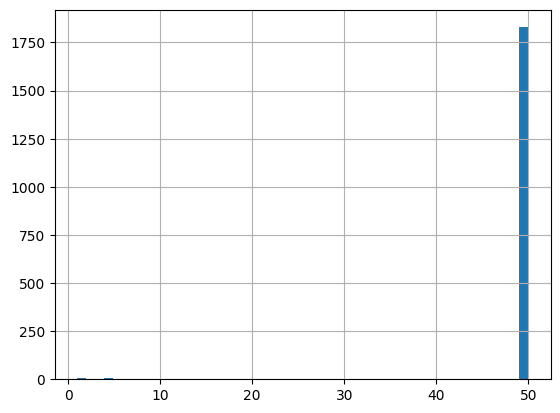

In [65]:
user_artists_df['userID'].value_counts().hist(bins=50)

In [66]:
user_artists_df['userID'].value_counts().value_counts()

count
50    1829
1        8
4        5
14       3
43       3
10       3
34       2
15       2
12       2
11       2
49       2
32       2
48       2
37       2
38       2
41       2
44       2
33       2
13       1
3        1
5        1
7        1
9        1
2        1
25       1
18       1
21       1
22       1
46       1
28       1
30       1
35       1
36       1
40       1
27       1
Name: count, dtype: int64

In [67]:
user_artists_df['userID'].nunique(), user_artists_df.loc[user_artists_df['levenshtein_similarity'] > 0,:]['userID'].nunique()

(1892, 1887)

We lost only 5 users due to joining on Spotify dataset.

In [68]:
left_users = user_artists_df.loc[user_artists_df['levenshtein_similarity'] > 0,:]['userID'].unique()

In [69]:
(
    (
    user_artists_df[user_artists_df['userID'].isin(left_users)]['userID'].value_counts() - 
    user_artists_df.loc[user_artists_df['levenshtein_similarity'] > 0,:]['userID'].value_counts()
    ) 
    / user_artists_df[user_artists_df['userID'].isin(left_users)]['userID'].value_counts()
).value_counts()

count
0.000000    671
0.020000    431
0.040000    282
0.060000    154
0.080000     98
0.100000     54
0.120000     42
0.140000     33
0.160000     16
0.180000     15
0.200000     13
0.220000      9
0.240000      9
0.066667      3
0.340000      3
0.260000      3
0.280000      3
0.420000      3
0.083333      2
0.046512      2
0.052632      2
0.300000      2
0.360000      2
0.320000      2
0.500000      2
0.071429      2
0.045455      1
0.580000      1
0.162162      1
0.194444      1
0.031250      1
0.660000      1
0.440000      1
0.113636      1
0.081081      1
0.074074      1
0.104167      1
0.111111      1
0.750000      1
0.460000      1
0.095238      1
0.540000      1
0.400000      1
0.121951      1
0.117647      1
0.073171      1
0.030303      1
0.068182      1
0.058824      1
0.130435      1
0.040816      1
0.279070      1
0.090909      1
0.057143      1
0.450000      1
Name: count, dtype: int64

In [70]:
(
    (
    user_artists_df[user_artists_df['userID'].isin(left_users)]['userID'].value_counts() - 
    user_artists_df.loc[user_artists_df['levenshtein_similarity'] > 0,:]['userID'].value_counts()
    ) 
    / user_artists_df[user_artists_df['userID'].isin(left_users)]['userID'].value_counts()
).value_counts() / user_artists_df[user_artists_df['userID'].isin(left_users)]['userID'].value_counts().shape[0]

count
0.000000    0.355591
0.020000    0.228405
0.040000    0.149444
0.060000    0.081611
0.080000    0.051934
0.100000    0.028617
0.120000    0.022258
0.140000    0.017488
0.160000    0.008479
0.180000    0.007949
0.200000    0.006889
0.220000    0.004769
0.240000    0.004769
0.066667    0.001590
0.340000    0.001590
0.260000    0.001590
0.280000    0.001590
0.420000    0.001590
0.083333    0.001060
0.046512    0.001060
0.052632    0.001060
0.300000    0.001060
0.360000    0.001060
0.320000    0.001060
0.500000    0.001060
0.071429    0.001060
0.045455    0.000530
0.580000    0.000530
0.162162    0.000530
0.194444    0.000530
0.031250    0.000530
0.660000    0.000530
0.440000    0.000530
0.113636    0.000530
0.081081    0.000530
0.074074    0.000530
0.104167    0.000530
0.111111    0.000530
0.750000    0.000530
0.460000    0.000530
0.095238    0.000530
0.540000    0.000530
0.400000    0.000530
0.121951    0.000530
0.117647    0.000530
0.073171    0.000530
0.030303    0.000530
0.06818

In majority of the cases there is just a slight or absolutely no changes in the number of artists listened per userID. 

In [71]:
user_artists_df.isnull().sum().sort_values(ascending=False)

top_track_explicit        58048
popularity_std            17560
popularity_min            15558
popularity_median         15558
popularity_mean           15558
                          ...  
levenshtein_similarity        0
name_translit                 0
artist_name_lastfm            0
weight                        0
userID                        0
Length: 69, dtype: int64

# Other Datasets

In [72]:
tags_df = pd.read_csv('../data/tags.dat', sep='\t', encoding='latin1')

In [73]:
tags_df.columns

Index(['tagID', 'tagValue'], dtype='object')

In [74]:
tags_df.tagValue.value_counts(dropna=False).reset_index()['count'].value_counts(dropna=False)

count
1    11946
Name: count, dtype: int64

In [75]:
pd.read_csv('../data/user_artists.dat', sep='\t').head()

,userID,artistID,weight
0,2,51,13883
1,2,52,11690
2,2,53,11351
3,2,54,10300
4,2,55,8983


In [76]:
user_df = pd.read_csv('../data/user_artists.dat', sep='\t')

In [77]:
user_df.shape[0], user_df['userID'].nunique(), user_df['artistID'].nunique()

(92834, 1892, 17632)

In [78]:
pd.read_csv('../data/user_friends.dat', sep='\t').head()

,userID,friendID
0,2,275
1,2,428
2,2,515
3,2,761
4,2,831


In [79]:
pd.read_csv('../data/user_taggedartists-timestamps.dat', sep='\t').columns

Index(['userID', 'artistID', 'tagID', 'timestamp'], dtype='object')

In [80]:
df_timestamps = pd.read_csv('../data/user_taggedartists-timestamps.dat', sep='\t')
df_timestamps["timestamp"] = pd.to_datetime(df_timestamps["timestamp"], unit="ms")

In [81]:
# Extract hour, day, and month
df_timestamps["hour"] = df_timestamps["timestamp"].dt.hour
df_timestamps["day"] = df_timestamps["timestamp"].dt.day
df_timestamps["weekday"] = df_timestamps["timestamp"].dt.weekday
df_timestamps["month"] = df_timestamps["timestamp"].dt.month

In [82]:
df_timestamps.head()

,userID,artistID,tagID,timestamp,hour,day,weekday,month
0,2,52,13,2009-03-31 22:00:00,22,31,1,3
1,2,52,15,2009-03-31 22:00:00,22,31,1,3
2,2,52,18,2009-03-31 22:00:00,22,31,1,3
3,2,52,21,2009-03-31 22:00:00,22,31,1,3
4,2,52,41,2009-03-31 22:00:00,22,31,1,3


In [83]:
df_timestamps['tagID'].value_counts().value_counts()

count
1      5373
2      1107
3       605
4       359
5       231
       ... 
335       1
334       1
331       1
327       1
184       1
Name: count, Length: 275, dtype: int64

In [84]:
df_timestamps['userID'].nunique()

1892

In [85]:
user_df['userID'].nunique()

1892

In [86]:
user_df.merge(df_timestamps, on = 'userID', how='left').isnull().sum()

userID        0
artistID_x    0
weight        0
artistID_y    0
tagID         0
timestamp     0
hour          0
day           0
weekday       0
month         0
dtype: int64

Every user has a recond in taggedartists-timestamps

In [87]:
df_timestamps.userID.value_counts().value_counts()

count
3       119
4        84
5        81
7        74
6        69
       ... 
174       1
173       1
170       1
393       1
2609      1
Name: count, Length: 382, dtype: int64

In [88]:
df_timestamps.columns

Index(['userID', 'artistID', 'tagID', 'timestamp', 'hour', 'day', 'weekday',
       'month'],
      dtype='object')

In [89]:
df_timestamps.shape

(186479, 8)

In [90]:
df_timestamps[['userID', 'artistID']].duplicated().sum()

np.int64(115415)

## Number of Nulls Per each Table

In [92]:
pd.read_csv('../data/user_artists.dat', sep='\t').isnull().sum()

userID      0
artistID    0
weight      0
dtype: int64

In [93]:
pd.read_csv('../data/user_taggedartists-timestamps.dat', sep='\t').isnull().sum()

userID       0
artistID     0
tagID        0
timestamp    0
dtype: int64

In [94]:
pd.read_csv('../data/user_friends.dat', sep='\t').isnull().sum()

userID      0
friendID    0
dtype: int64

In [95]:
pd.read_csv('../data/tags.dat', sep='\t',  encoding='latin1').isnull().sum()

tagID       0
tagValue    0
dtype: int64

In [96]:
pd.read_parquet('../data/artists_spotify_matched.parquet').isnull().sum().sort_values(ascending=False)

top_track_explicit        15616
popularity_std             9521
popularity_min             8748
popularity_median          8748
popularity_mean            8748
                          ...  
valence_mean               2770
artist_name_lastfm            0
levenshtein_similarity        0
name_translit                 0
id                            0
Length: 67, dtype: int64

In [103]:
import pandas as pd
df = pd.read_parquet('../data/artists_spotify_matched.parquet')

In [104]:
df.head()

,id,artist_name_lastfm,name_translit,levenshtein_similarity,artist_name_spotify,top_track_name,top_track_popularity,top_track_duration_ms,top_track_explicit,top_track_danceability,...,speechiness_mean,speechiness_median,speechiness_min,speechiness_max,speechiness_std,popularity_mean,popularity_median,popularity_min,popularity_std,track_name_count
0,1,MALICE MIZER,malice mizer,0.0,None,None,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Diary of Dreams,diary of dreams,100.0,Diary Of Dreams,Beyond the Void,34.0,260733.0,NaN,0.566,...,0.039522,0.03635,0.0240,0.0846,0.012713,18.857143,17.0,4.0,8.283012,88.0
2,3,Carpathian Forest,carpathian forest,100.0,Carpathian Forest,Bloody Fucking Nekro Hell,36.0,65573.0,NaN,0.155,...,0.077168,0.06300,0.0258,0.2980,0.053348,14.512500,14.0,3.0,6.873161,103.0
3,4,Moi dix Mois,moi dix mois,0.0,None,None,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,Bella Morte,bella morte,100.0,Bella Morte,Fall No More,19.0,305640.0,NaN,0.519,...,0.046794,0.03700,0.0269,0.2970,0.036412,4.627907,3.0,0.0,3.964265,65.0


Only artists_spotify_matched.parquet file contains nulls, caused by merging on Spotify dataset.